In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.realpath('..'))

In [2]:
import numpy as np
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go

from copy import deepcopy

from tracking_v2.target import NearConstantVelocityTarget
from tracking_v2.tracker import Track, Tracker
from tracking_v2.kalman import linear_ncv
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import TrackerRunner, FilterRunner, evaluate_nees, evaluate_runner, plot_nscore
import tracking_v2.evaluation.runner as runner

from tracking_v2.util import to_df, display

In [3]:
display.as_png = False

In [4]:
TRACK_ID = 0

class TwoPointInitializationTracker(Tracker):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.first_meas = None
        self.kf = None
        self.time = None
    
    def add_measurements(self, ms):
        assert len(ms) == 1, "more than 1 measurement not supported"
        assert len(ms[0].z.squeeze()) == 3, "only 3D spaces are supported"

        if self.first_meas is None:
            self.first_meas = ms[0]
        
        elif self.kf is None:
            dt = ms[0].time - self.first_meas.time
            dp = ms[0].z - self.first_meas.z
            
            vel = dp / dt
            P_vel = (self.first_meas.R + ms[0].R) / (dt * dt)
            P_pos_vel = ms[0].R / dt
            
            x = np.concatenate((ms[0].z.squeeze(), vel.squeeze()))
            P = np.zeros((6, 6))
            P[:3, :3] = ms[0].R
            P[3:, 3:] = P_vel
            P[:3, 3:] = P_pos_vel
            P[3:, :3] = P_pos_vel
            
            self.kf = linear_ncv(noise_intensity=1)
            self.kf.initialize(x, P)
            self.time = ms[0].time

        else:
            dt = ms[0].time - self.time
            self.kf.predict(dt)
            self.kf.calculate_innvovation(ms[0].z, ms[0].R)
            self.kf.update()
            self.time = ms[0].time
    
    def estimate_tracks(self, t: float):
        if self.kf is None:
            return []
        
        assert t == self.time, "cannot estimate tracks for arbitrary t"    
        return [Track(TRACK_ID, self.kf.x_hat, self.kf.P_hat)]

## Two-point initialization

No error in the first ~25 iterations - initialized with velocity estimate matching the real velocity well enough.

In [5]:
r1 = TrackerRunner([NearConstantVelocityTarget(noise_intensity=1)], [GeometricSensor()], TwoPointInitializationTracker())
r1.run_many(50, 400)

In [6]:
fake = FilterRunner(None, None, None)
fake.many_x_hat = np.asarray([one_x_hat[TRACK_ID] for one_x_hat in r1.many_x_hat])
fake.many_P_hat = np.asarray([one_P_hat[TRACK_ID] for one_P_hat in r1.many_P_hat])
fake.many_truth = np.asarray([one_truths[0,2:,:] for one_truths in r1.many_truths])

In [7]:
e1 = evaluate_nees(fake.many_x_hat[:,:,:3,:], fake.many_P_hat[:,:,:3,:3], fake.many_truth[:,:,:3])

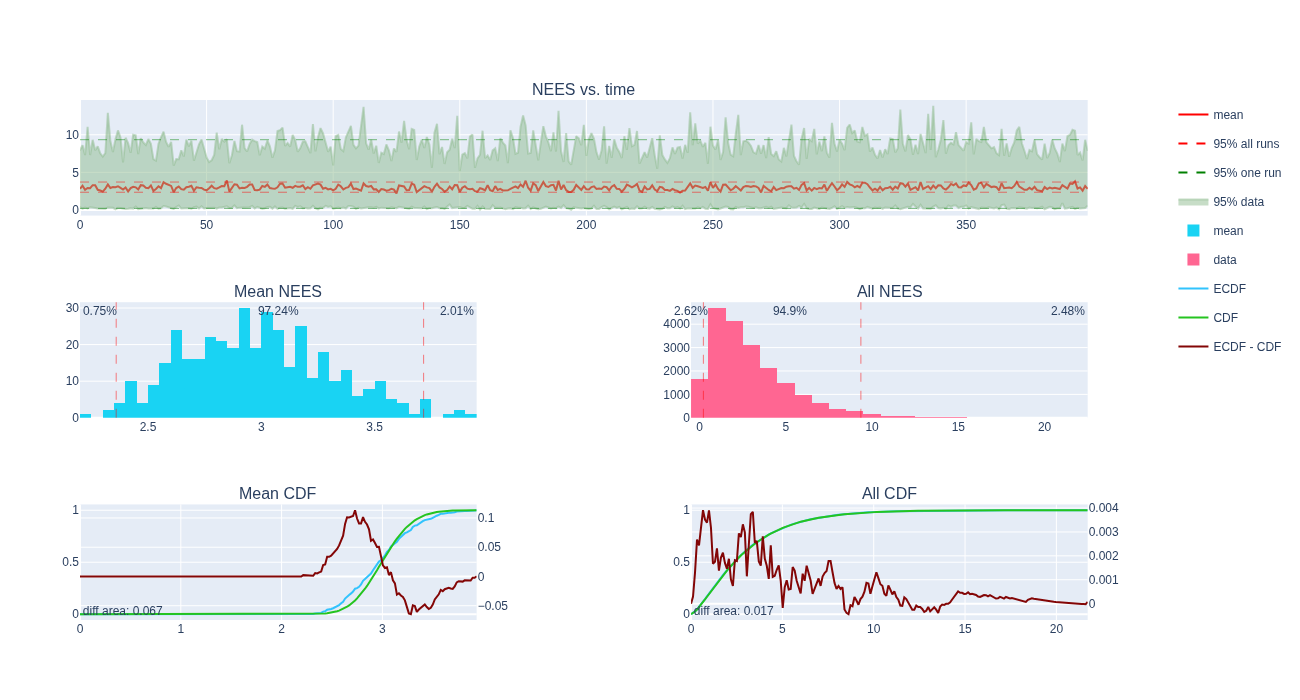

In [8]:
display(plot_nscore(e1, skip=0))

## Regular initialization

Exhibits large NEES in the first ~25 iterations.

In [9]:
r2 = FilterRunner(NearConstantVelocityTarget(noise_intensity=1), GeometricSensor(), linear_ncv(1))
r2.run_many(50, 400)

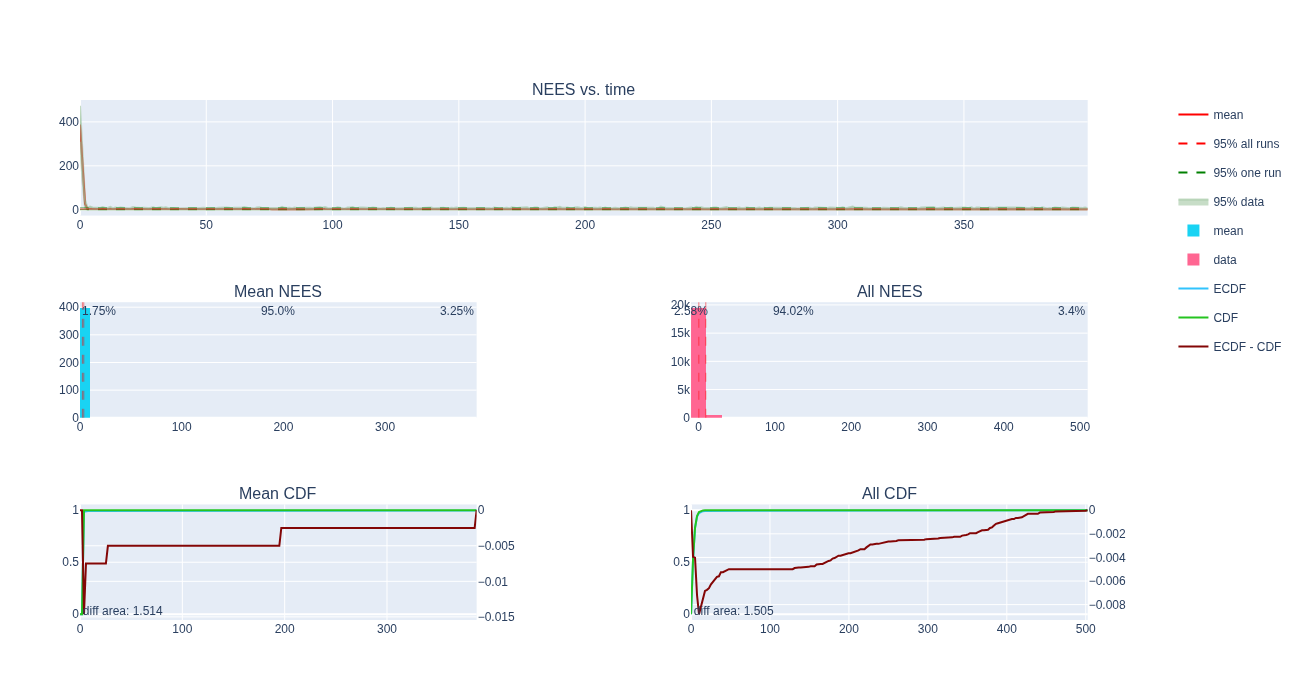

In [10]:
e2 = evaluate_runner(r2)
display(plot_nscore(e2.position_nees, skip=0))